<a href="https://colab.research.google.com/github/haoz07/nyu_datathon_team_4/blob/master/Copy_of_Copy_of_nyu_sedation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Structure of this notebook
---
1. Data extraction
2. Descriptive statistics
3. Modeling (separate notebook)

## Data Extraction 
--- 
* imports
* connect to database
* extract sedatives
* extract cohort caracteristics
* merge cohort caracteristics and sedatives

In [0]:
import os
import sys
import pandas as pd 
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML
%matplotlib inline

# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

pd.set_option("display.max_rows", 999)

In [0]:
auth.authenticate_user()
project_id='hst-953-2018'
project_id='nyu-datathon'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, configuration={'query':{'useLegacySql': False}})


*   Query for all input events containing the aformentioned medications.
* Calculate duration in hours for each input event
* Drop rows where endtimes came before starttime
* Round up duration




In [0]:
q = '''select *
from `physionet-data.mimiciii_clinical.inputevents_mv`
where itemid in (221744,222168,225942,225150) and STATUSDESCRIPTION != 'Rewritten'
'''
df_sed = run_query(q)

df_sed = df_sed[df_sed['ENDTIME'] > df_sed['STARTTIME']]
df_sed['DURATION'] = (df_sed['ENDTIME'] - df_sed['STARTTIME']) / pd.Timedelta(1, 'h')
df_sed.DURATION = df_sed.DURATION.apply(np.ceil)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  import sys


 Adjust units so that they are all comparable
 --- 
 Change unit of Fentanyl and Dexme to mcg, and Propofol and Fentanyl (Continuous) to mg

In [0]:

# Fentanyl
sed_fent = df_sed.loc[df_sed['ITEMID'] == 221744, :]
sed_fent.loc[:,'AMOUNT'] = np.where(sed_fent['AMOUNTUOM'] == 'mcg',
                              sed_fent['AMOUNT'],
                              sed_fent['AMOUNT'] * 1000)
sed_fent.loc[:,'AMOUNTUOM'] = np.where(sed_fent['AMOUNTUOM'] == 'mcg',
                                       sed_fent['AMOUNTUOM'],
                                       'mcg')
# Dexme
sed_dex = df_sed.loc[df_sed['ITEMID'] == 225150, :]
sed_dex.loc[:,'AMOUNT'] = np.where(sed_dex['AMOUNTUOM'] == 'mcg',
                              sed_dex['AMOUNT'],
                              sed_dex['AMOUNT'] * 1000)
sed_dex.loc[:,'AMOUNTUOM'] = np.where(sed_dex['AMOUNTUOM'] == 'mcg',
                                       sed_dex['AMOUNTUOM'],
                                       'mcg')

# Propofol
sed_pro = df_sed.loc[df_sed['ITEMID'] == 222168, :]
sed_pro.loc[:,'AMOUNT'] = np.where(sed_pro['AMOUNTUOM'] == 'mg',
                              sed_pro['AMOUNT'],
                              sed_pro['AMOUNT']/1000)
sed_pro.loc[:,'AMOUNTUOM'] = np.where(sed_pro['AMOUNTUOM'] == 'mg',
                                       sed_pro['AMOUNTUOM'],
                                       'mg')

# Fentanyl (Concentrate)
sed_fent_con = df_sed.loc[df_sed['ITEMID'] == 225942, :]
sed_fent_con.loc[:,'AMOUNT'] = np.where(sed_fent_con['AMOUNTUOM'] == 'mg',
                              sed_fent_con['AMOUNT'],
                              sed_fent_con['AMOUNT']/1000)
sed_fent_con.loc[:,'AMOUNTUOM'] = np.where(sed_fent_con['AMOUNTUOM'] == 'mg',
                                       sed_fent_con['AMOUNTUOM'],
                                       'mg')

df_sed_uni = pd.concat([sed_fent, sed_dex, sed_pro, sed_fent_con])
df_sed_uni['RATE_CALC'] = df_sed_uni['AMOUNT'] / df_sed_uni['DURATION']

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Extract the cohort characteristics
---
* Demographics
* Comorbidities
* Exclusion criteria: cardiac arrest, cebrovascular and patients who got midazolam


In [0]:
q = '''select i.subject_id, i.icustay_id, first_careunit, gender, expire_flag, intime, outtime, 
DATETIME_DIFF(intime, p.dob, YEAR) AS age, height, weight, eq.*, elixhauser_vanwalraven,
sofa, DATETIME_DIFF(dod, intime, DAY) AS days_until_death, hospital_expire_flag


from `physionet-data.mimiciii_clinical.icustays` i

left join `physionet-data.mimiciii_clinical.admissions` ads
on ads.hadm_id=i.hadm_id


left join `physionet-data.mimiciii_clinical.patients` p
on p.subject_id=i.subject_id


left join `physionet-data.mimiciii_derived.ventdurations` v 
on v.icustay_id=i.icustay_id

left join `physionet-data.mimiciii_derived.elixhauser_quan` eq
on eq.hadm_id=i.hadm_id

left join `physionet-data.mimiciii_derived.elixhauser_quan_score` es
on es.hadm_id=i.hadm_id


left join `physionet-data.mimiciii_derived.sofa` sof
on sof.icustay_id=i.icustay_id


left join `physionet-data.mimiciii_derived.heightfirstday` hei
on hei.icustay_id=i.icustay_id


left join `physionet-data.mimiciii_derived.weightfirstday` wei
on wei.icustay_id=i.icustay_id

where i.first_careunit = 'MICU' and
v.duration_hours > 24
'''


df_static = run_query(q)

print('%d icustays for %d patients.' % (df_static.icustay_id.nunique(), df_static.subject_id.nunique()))

df_static = df_static[df_static.age >= 18]
df_static['age'] = np.where(df_static.age >= 300, df_static.age - 300 + 91.4, df_static.age)

print('%d icustays for %d patients.' % (df_static.icustay_id.nunique(), df_static.subject_id.nunique()))
q = '''select subject_id, hadm_id
from `physionet-data.mimiciii_clinical.diagnoses_icd` d
where SUBSTR(d.icd9_code,1,  4) in ('3453', '4275')
'''

df = run_query(q)
df.head()
print('%d patients.' % (df.subject_id.nunique()))
df['excluded_cardiac_arrest'] = 1
df_static = df_static.merge(df[['hadm_id', 'excluded_cardiac_arrest']], on='hadm_id', how='left')

df_static = df_static[df_static.excluded_cardiac_arrest != 1]
print('After restricting to adults: %d icustays for %d patients.' % (df_static.icustay_id.nunique(), df_static.subject_id.nunique()))

print(df_static.weight.count(), df_static.height.count())
df_static = df_static[(df_static.weight > 23) & (df_static.height > 90) & (df_static.height < 220)]
print(len(df_static))
df_static.height = df_static.height.astype(float)
df_static.weight = df_static.weight.astype(float)
df_static.sofa = df_static.sofa.astype(float)
df_static.elixhauser_vanwalraven = df_static.elixhauser_vanwalraven.astype(float)
df_static['bmi'] = 10000 * (df_static.weight / (df_static.height * df_static.height ))



q = '''select subject_id, hadm_id, 
case
    when d.drg_code between 020 and 022 then 1
    when d.drg_code between 034 and 039 then 1
    when d.drg_code between 064 and 072 then 1
else 0 end as cerebrovascular

from `physionet-data.mimiciii_clinical.drgcodes` d


'''

df = run_query(q)
df = df[df.cerebrovascular == 1]
df_static['cerebrovascular'] = 0
df_static.loc[df_static.hadm_id.isin(df.hadm_id), 'cerebrovascular'] = 1 
print('cerebrovascular to exclude.', df_static.cerebrovascular.sum())
df_static = df_static[df_static.cerebrovascular != 1]


q = '''select distinct icustay_id, 1 as midazolam

from `physionet-data.mimiciii_clinical.inputevents_mv` 
where itemid=221668 and rate is not Null
'''
df = run_query(q)
df_static = df_static.merge(df, on='icustay_id', how='left')
print('midazolam icus', df_static.midazolam.sum())
df_static = df_static[df_static.midazolam != 1]
df_static['bmi_groups'] = 'non-obese'
msk = (df_static.bmi >= 30) & (df_static.bmi < 40)
df_static.loc[msk, 'bmi_groups'] = 'Class 1 & 2 obese'
msk = (df_static.bmi >= 40) 
df_static.loc[msk, 'bmi_groups'] = 'Class 3 obese'

cont_cols = ['age', 'height', 'weight', 'bmi','sofa',  'elixhauser_vanwalraven']

comorb_cols = ['CONGESTIVE_HEART_FAILURE', 'CARDIAC_ARRHYTHMIAS', 'VALVULAR_DISEASE',
       'PULMONARY_CIRCULATION', 'PERIPHERAL_VASCULAR', 'HYPERTENSION',
       'PARALYSIS', 'OTHER_NEUROLOGICAL', 'CHRONIC_PULMONARY',
       'DIABETES_UNCOMPLICATED', 'DIABETES_COMPLICATED', 'HYPOTHYROIDISM',
       'RENAL_FAILURE', 'LIVER_DISEASE', 'PEPTIC_ULCER', 'AIDS', 'LYMPHOMA',
       'METASTATIC_CANCER', 'SOLID_TUMOR', 'RHEUMATOID_ARTHRITIS',
       'COAGULOPATHY', 'OBESITY', 'WEIGHT_LOSS', 'FLUID_ELECTROLYTE',
       'BLOOD_LOSS_ANEMIA', 'DEFICIENCY_ANEMIAS', 'ALCOHOL_ABUSE',
       'DRUG_ABUSE', 'PSYCHOSES', 'DEPRESSION']



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  import sys


6715 icustays for 5736 patients.
6712 icustays for 5733 patients.
1548 patients.
After restricting to adults: 6316 icustays for 5407 patients.
5748 4076
3833
cerebrovascular to exclude. 61
midazolam icus 870.0


In [0]:
df_inputs = df_sed_uni[df_sed_uni.ICUSTAY_ID.isin(df_static.icustay_id)]
df_inputs.rename({"ICUSTAY_ID": 'icustay_id'}, axis=1, inplace=True)
df_inputs = df_inputs.merge(df_static[['icustay_id', 'intime']], how='left', on='icustay_id')
df_inputs['start_hour'] = (df_inputs.STARTTIME - df_inputs.intime)/pd.Timedelta(1, 'h')
df_inputs['end_hour'] = (df_inputs.ENDTIME - df_inputs.intime)/pd.Timedelta(1, 'h')
df_inputs['end_hour'] = df_inputs['end_hour'].apply(np.ceil).astype(int)
df_inputs['start_hour'] = df_inputs['start_hour'].apply(np.ceil).astype(int)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Extract mechanical ventilatin hourly

In [0]:
"""
vent durations
"""
q = '''select *
from `physionet-data.mimiciii_derived.ventdurations`
'''
df_vent = run_query(q)

df_merged = df_vent.merge(df_static[['icustay_id', 'intime']], on='icustay_id', how='left')
df_merged = df_merged[~df_merged.intime.isna()]
df_merged['start_hour'] = (df_merged.starttime - df_merged.intime)/pd.Timedelta(1, 'h')
df_merged['end_hour'] = (df_merged.endtime - df_merged.intime)/pd.Timedelta(1, 'h')
df_merged['end_hour'] = df_merged['end_hour'].apply(np.ceil).astype(int)
df_merged['start_hour'] = df_merged['start_hour'].apply(np.ceil).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  import sys


## Merge everything together
---
* the hourly medications and ventilation
* the demographics
* combine the two

In [0]:
list_of_frames = []
'''
Tranform overlapped cohort input events to hourly dosage for each ICU stay
Final dataframe contains the following features: 
subject_id, hadm_id, icustay_id, hour, Fentanyl, Propofol, 
Fentanyl (Concentration), and 'Dexmedetomidine'

'''
for icustay_id, subset in df_inputs.groupby('icustay_id'):
    # obtain ids, and max_hours
    subject_id = max(subset.SUBJECT_ID)
    hadm_id = max(subset.HADM_ID)
    max_hours = max(subset.end_hour) + 1
    # repeat the row max hour number of times
    temp = np.tile([subject_id, hadm_id, icustay_id, 0, 0, 0, 0, 0, 0], (max_hours, 1))
    # convert to dataframe
    temp = pd.DataFrame(temp, columns=['subject_id', 'hadm_id', 'icustay_id', 'hour', 
                                'Fentanyl', 'Propofol', 'Fentanyl (Concentration)', 
                                       'Dexmedetomidine', 'vent'])
    temp['hour'] = np.arange(0, max_hours)
    # transform each input event into hourly dosage in the final dataframe
    for _, row in subset.iterrows():
      if (row.loc['end_hour'] == row.loc['start_hour']):
        # Fentanyl
        if row.loc['ITEMID'] == 221744:
          temp.iloc[row.loc['start_hour'], 4] = row.loc['AMOUNT']
        # Propofol
        if row.loc['ITEMID'] == 222168:
          temp.iloc[row.loc['start_hour'], 5] = row.loc['AMOUNT']
        # Fentanyl (Concentrate)
        if row.loc['ITEMID'] == 225942:
          temp.iloc[row.loc['start_hour'], 6] = row.loc['AMOUNT']
        # Dexmedetomidine
        if row.loc['ITEMID'] == 225150:
          temp.iloc[row.loc['start_hour'], 7] = row.loc['AMOUNT']
      else:
        # Fentanyl
        if row.loc['ITEMID'] == 221744:
          temp.iloc[row.loc['start_hour']:row.loc['end_hour'], 4] = row.loc['AMOUNT'] / (row.loc['end_hour'] - row.loc['start_hour'])
        # Propofol
        if row.loc['ITEMID'] == 222168:
          temp.iloc[row.loc['start_hour']:row.loc['end_hour'], 5] = row.loc['AMOUNT'] / (row.loc['end_hour'] - row.loc['start_hour'])
        # Fentanyl (Concentrate)
        if row.loc['ITEMID'] == 225942:
          temp.iloc[row.loc['start_hour']:row.loc['end_hour'], 6] = row.loc['AMOUNT'] / (row.loc['end_hour'] - row.loc['start_hour'])
        # Dexmedetomidine
        if row.loc['ITEMID'] == 225150:
          temp.iloc[row.loc['start_hour']:row.loc['end_hour'], 7] = row.loc['AMOUNT'] / (row.loc['end_hour'] - row.loc['start_hour'])
    vent_hours = df_merged.loc[df_merged['icustay_id'] == icustay_id, ['start_hour', 'end_hour']]
    vent_hours.reset_index(inplace=True)
    temp.iloc[vent_hours.loc[0, 'start_hour']:vent_hours.loc[0, 'end_hour'], 8] = 1
    list_of_frames.append(temp)

In [0]:
hourly_dose = pd.concat(list_of_frames, axis=0)

## Add our targets
---
* Rass and Cam-icu score

In [0]:
# cam-icu
q = '''select icustay_id, charttime, valuenum as camicu
from `physionet-data.mimiciii_clinical.chartevents`
where itemid in (228300, 228337) and valuenum is not null
'''
df = run_query(q)
df = df[df.icustay_id.isin(df_static.icustay_id)]
df = df.merge(df_static[['icustay_id', 'intime']], on='icustay_id', how='left')
df['hour'] = (df.charttime - df.intime) / pd.Timedelta(1, 'h')
df['hour'] = df['hour'].apply(np.ceil)

hourly_dose = hourly_dose.merge(df[['icustay_id', 'hour', 'camicu']], how='left', on=['icustay_id', 'hour'])

# rass
q = '''select icustay_id, charttime, valuenum as rass
from `physionet-data.mimiciii_clinical.chartevents`
where itemid=228096 and valuenum is not null
'''
df = run_query(q)
df = df[df.icustay_id.isin(df_static.icustay_id)]
df = df.merge(df_static[['icustay_id', 'intime']], on='icustay_id', how='left')
df['hour'] = (df.charttime - df.intime) / pd.Timedelta(1, 'h')
df['hour'] = df['hour'].apply(np.ceil)

hourly_dose = hourly_dose.merge(df[['icustay_id', 'hour', 'rass']], how='left', on=['icustay_id', 'hour'])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  import sys


In [0]:
hourly_dose_final = df_static[['subject_id', 'icustay_id', 'first_careunit', 'gender', 'expire_flag',
       'intime', 'outtime', 'age', 'height', 'weight', 'hadm_id', 'bmi', 'bmi_groups']  + comorb_cols].merge(hourly_dose[['icustay_id', 'hour', 'Fentanyl', 'Propofol',
       'Fentanyl (Concentration)', 'Dexmedetomidine', 'vent', 'camicu',
       'rass']], how='left', on='icustay_id')

In [0]:
hourly_dose_final[['bmi_groups', 'icustay_id']].drop_duplicates().groupby('bmi_groups').count()

,icustay_id
bmi_groups,
Class 1 & 2 obese,722
Class 3 obese,291
non-obese,1889


## Filter one strange outlier patient and patients that were not in metavision

In [0]:
hourly_dose_final = hourly_dose_final[hourly_dose_final.icustay_id != 278873]
df = hourly_dose_final[~hourly_dose_final.Fentanyl.isna()]


## Save final version of data
---
This data is loaded in other notebook and used for model training. 
In the following, we only make some statistics for our slides and to deepen understanding

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

df.to_csv('/content/gdrive/My Drive/sedation_cohort.csv', index=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Make statistics and plots to understand data
--- 
* Patient demographics
* Mortality
* Comorbidity per group
* sedation per group and over time

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/My Drive/sedation_cohort.csv')
print(len(df), df.icustay_id.nunique())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
36454 462


In [0]:
df[['bmi_groups', 'icustay_id']].drop_duplicates().groupby('bmi_groups').count()

,icustay_id
bmi_groups,
Class 1 & 2 obese,123
Class 3 obese,40
non-obese,299


In [0]:
msk = df_static.bmi_groups  == 'non-obese'
c = 'age'
stats.ttest_ind(df_static[msk][c],df_static[~msk][c], equal_var = False)[1]

3.6097137022369316e-09

In [0]:
df_static = df_static[df_static.icustay_id.isin(df.icustay_id)]
df_static['los'] = (df_static.outtime - df_static.intime) / pd.Timedelta(1, 'd')

for c in ['age', 'los', 'elixhauser_vanwalraven', 'los', 'sofa']:
  print(c)
  x = df_static[['bmi_groups', c]].groupby('bmi_groups').mean().reset_index().rename({c: c + ' mean'},axis=1)
  y = df_static[['bmi_groups', c]].groupby('bmi_groups').std().reset_index().rename({c: c + ' std'},axis=1)
  z = x.merge(y, on='bmi_groups', how='outer')
  print(z)

age
          bmi_groups   age mean    age std
0  Class 1 & 2 obese  61.526829  14.548895
1      Class 3 obese  56.885000  16.098918
2          non-obese  65.743813  16.966047
los
          bmi_groups  los mean   los std
0  Class 1 & 2 obese  5.882802  5.309799
1      Class 3 obese  5.837757  4.556927
2          non-obese  5.913182  6.121092
elixhauser_vanwalraven
          bmi_groups  elixhauser_vanwalraven mean  elixhauser_vanwalraven std
0  Class 1 & 2 obese                    11.634146                    9.473231
1      Class 3 obese                     8.925000                    8.653997
2          non-obese                    14.341137                    9.538197
los
          bmi_groups  los mean   los std
0  Class 1 & 2 obese  5.882802  5.309799
1      Class 3 obese  5.837757  4.556927
2          non-obese  5.913182  6.121092
sofa
          bmi_groups  sofa mean  sofa std
0  Class 1 & 2 obese   5.040650  3.766545
1      Class 3 obese   4.125000  2.573908
2          non-obese  

In [0]:
df_static.gender = np.where(df_static.gender == 'F', 1, 0)
for c in ['hospital_expire_flag', 'gender']:
  df_static[['bmi_groups', c]].groupby('bmi_groups').mean()

In [0]:
for cnt, c in enumerate(cont_cols):
  df_static[c] = df_static[c].fillna(0).astype(int)
  x = df_static[['bmi_groups', c]].groupby('bmi_groups').median().reset_index()
  if cnt == 0:
    stat = x
  else:
    stat = stat.merge(x, on='bmi_groups')
print(stat)

for cnt, c in enumerate(comorb_cols):
  df_static[c] = df_static[c].fillna(0).astype(int)
  x = df_static[['bmi_groups', c]].groupby('bmi_groups').mean().reset_index()
  if cnt == 0:
    stat = x
  else:
    stat = stat.merge(x, on='bmi_groups')
stat.loc[[2, 0, 1], ['bmi_groups', 'CONGESTIVE_HEART_FAILURE', 'HYPERTENSION', 'CHRONIC_PULMONARY', 'DIABETES_UNCOMPLICATED', 'DIABETES_COMPLICATED', 'ALCOHOL_ABUSE', 'DRUG_ABUSE', 'PSYCHOSES']]


          bmi_groups  age  height  weight   bmi  sofa  elixhauser_vanwalraven
0  Class 1 & 2 obese   62     170      99  33.0     4                      11
1      Class 3 obese   59     169     133  48.5     4                       7
2          non-obese   67     170      68  24.0     4                      14


,bmi_groups,CONGESTIVE_HEART_FAILURE,HYPERTENSION,CHRONIC_PULMONARY,DIABETES_UNCOMPLICATED,DIABETES_COMPLICATED,ALCOHOL_ABUSE,DRUG_ABUSE,PSYCHOSES
2,non-obese,0.324415,0.548495,0.321070,0.133779,0.083612,0.150502,0.076923,0.023411
0,Class 1 & 2 obese,0.308943,0.569106,0.317073,0.268293,0.162602,0.154472,0.073171,0.024390
1,Class 3 obese,0.450000,0.750000,0.375000,0.375000,0.125000,0.150000,0.025000,0.100000


In [0]:
df = hourly_dose_final[~hourly_dose_final.Fentanyl.isna()]
cols = ['Fentanyl', 'Propofol']
df['max_amount'] = df[cols].max(axis=1)
x_med = df[['icustay_id', 'hour']][df.max_amount  > 0].groupby('icustay_id').max().rename({'hour': 'med_weaned'}, axis=1)
x_mv = df[['icustay_id', 'hour']][df.vent  > 0].groupby('icustay_id').max().reset_index().rename({'hour': 'mech_weaned'}, axis=1)
x = x_med.merge(x_mv, on='icustay_id', how='outer')
x = x.merge(df[['icustay_id', 'bmi_groups']], on='icustay_id', how='left')
x['diff_in_hours'] = x.mech_weaned - x.med_weaned

print(x[['bmi_groups', 'diff_in_hours']].groupby('bmi_groups').mean() * 60, x[['bmi_groups', 'diff_in_hours']].groupby('bmi_groups').std() * 60)

                   diff_in_hours
bmi_groups                      
Class 1 & 2 obese     116.258434
Class 3 obese          55.318315
non-obese              93.719580                    diff_in_hours
bmi_groups                      
Class 1 & 2 obese     373.117503
Class 3 obese          81.230865
non-obese             420.175353


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

#Static
df.to_csv('/content/gdrive/My Drive/sedation_cohort.csv', index=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
for cnt, c in enumerate(['vent', 'Fentanyl', 'Propofol', 'Dexmedetomidine', 'rass']):
  if c == 'vent':
    x = df[[c, 'bmi_groups', 'icustay_id']].groupby(['icustay_id', 'bmi_groups']).sum().reset_index()
  else:
    msk = (df.vent == 1) & (df[c]> 0)
    x = df[[c, 'bmi_groups', 'icustay_id']][msk].groupby(['icustay_id', 'bmi_groups']).mean().reset_index()
    y = df[[c, 'bmi_groups', 'icustay_id', 'weight']][msk]  
    y[c] = y[c] / y['weight']
    y = y.groupby(['icustay_id', 'bmi_groups']).mean().reset_index()
    y = y[[c, 'bmi_groups']].groupby('bmi_groups').mean().reset_index().rename({c: c + '_perweight'}, axis=1)
    
    z = df[[c, 'bmi_groups', 'icustay_id']][msk] 
    z = z.groupby(['icustay_id', 'bmi_groups']).sum().reset_index()
    z = z[[c, 'bmi_groups']].groupby('bmi_groups').mean().reset_index().rename({c: c + '_perventilation'}, axis=1)
    
  x = x[[c, 'bmi_groups']].groupby('bmi_groups').mean().reset_index()
  
  if cnt == 0:
    stat = x
  else:
    x = x.merge(y, on='bmi_groups', how='left')
    x = z.merge(y, on='bmi_groups', how='left')
    
    stat = stat.merge(x, how='left', on='bmi_groups')
stat.loc[[2, 0, 1], :]


,bmi_groups,vent,Fentanyl_perventilation,Fentanyl_perweight,Propofol_perventilation,Propofol_perweight,Dexmedetomidine_perventilation,Dexmedetomidine_perweight,rass_perventilation,rass_perweight
2,non-obese,76.474916,445.404355,0.607749,4145.913838,1.642301,406.954043,0.374907,4.513158,0.018849
0,Class 1 & 2 obese,77.650407,366.137762,0.429730,6137.534629,1.687032,980.927302,0.436895,6.500000,0.014773
1,Class 3 obese,74.425000,379.447515,0.323738,8494.202997,1.539090,252.173965,0.310983,3.933333,0.011035


In [0]:
def get_x_for_msk(msk_hour):
  for cnt, c in enumerate(['vent', 'Propofol', 'Dexmedetomidine', 'Fentanyl']):
    if c == 'vent':
      x = df[[c, 'bmi_groups', 'icustay_id']][msk_hour].groupby(['icustay_id', 'bmi_groups']).sum().reset_index()
    else:
      msk = (df.vent == 1) & (df[c]> 0) & msk_hour
      x = df[[c, 'bmi_groups', 'icustay_id']][msk].groupby(['icustay_id', 'bmi_groups']).mean().reset_index()
      y = df[[c, 'bmi_groups', 'icustay_id', 'weight']][msk]  
      y[c] = y[c] / y['weight']
      y = y.groupby(['icustay_id', 'bmi_groups']).mean().reset_index()
      y = y[[c, 'bmi_groups']].groupby('bmi_groups').mean().reset_index().rename({c: c + '_perweight'}, axis=1)

      z = df[[c, 'bmi_groups', 'icustay_id']][msk] 
      z = z.groupby(['icustay_id', 'bmi_groups']).sum().reset_index()
      z = z[[c, 'bmi_groups']].groupby('bmi_groups').mean().reset_index().rename({c: c + '_perventilation'}, axis=1)

    x = x[[c, 'bmi_groups']].groupby('bmi_groups').mean().reset_index()

    if cnt == 0:
      stat = x
    else:
      x = x.merge(y, on='bmi_groups', how='left')
      x = x.merge(z, on='bmi_groups', how='left')

      stat = stat.merge(x, how='left', on='bmi_groups')
  return stat



msk_hour = df.hour < 25
x = get_x_for_msk(msk_hour)
x['day'] = 1
nb_df = df[['icustay_id', 'bmi_groups']][msk_hour].drop_duplicates().groupby('bmi_groups').count().reset_index()
x = x.merge(nb_df, on='bmi_groups', how='left')

msk_hour = (df.hour> 24) & (df.hour < 49)
y = get_x_for_msk(msk_hour)
y['day'] = 2
nb_df = df[['icustay_id', 'bmi_groups']][msk_hour].drop_duplicates().groupby('bmi_groups').count().reset_index()
y = y.merge(nb_df, on='bmi_groups', how='left')

stat = pd.concat((x, y), axis=0)

msk_hour = (df.hour> 48) & (df.hour < 73)
y = get_x_for_msk(msk_hour)
nb_df = df[['icustay_id', 'bmi_groups']][msk_hour].drop_duplicates().groupby('bmi_groups').count().reset_index()
y = y.merge(nb_df, on='bmi_groups', how='left')
y['day'] = 3
stat = pd.concat((stat, y), axis=0)

msk_hour = (df.hour> 72) & (df.hour < 97)
y = get_x_for_msk(msk_hour)
nb_df = df[['icustay_id', 'bmi_groups']][msk_hour].drop_duplicates().groupby('bmi_groups').count().reset_index()
y = y.merge(nb_df, on='bmi_groups', how='left')
y['day'] = 4

stat.to_csv('/content/gdrive/My Drive/sedation_sums.csv', index=False)
stat = pd.concat((stat, y), axis=0)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


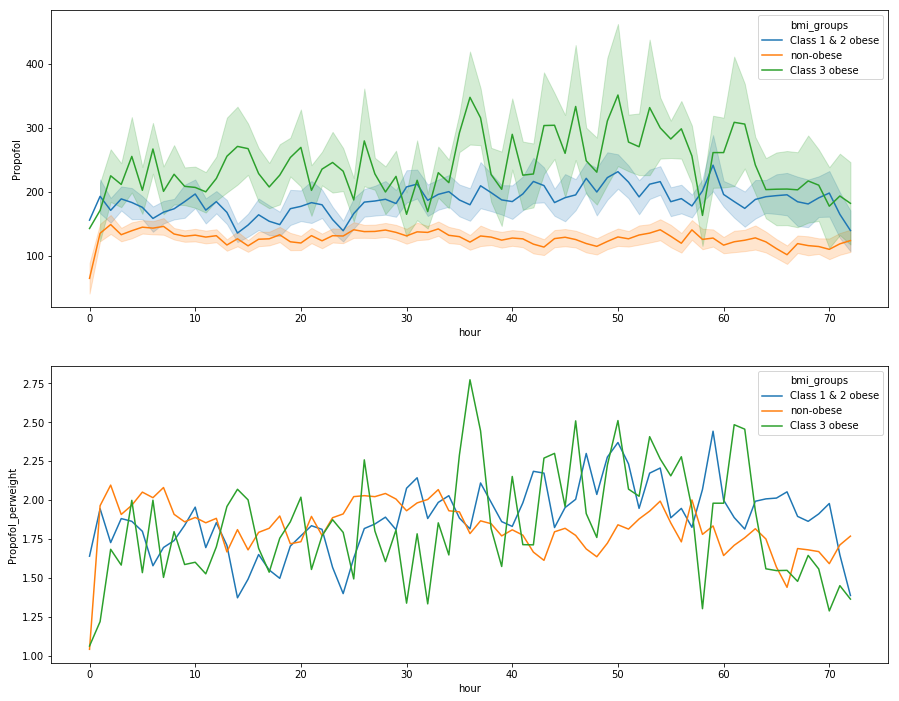

In [0]:
c = 'Propofol'
msk = (df[c] > 0) & (df.hour <73) & (df.vent > 0)
df[c + '_perweight'] = df[c] / df.weight
x = df[msk]
fig, ax = plt.subplots(nrows=2, figsize=(15, 12))
sns.lineplot(x=x.hour, y=x[c], hue=x.bmi_groups, ci=75, ax=ax[0])
sns.lineplot(x=x.hour, y=x[c + '_perweight'], hue=x.bmi_groups, ci=None, ax=ax[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


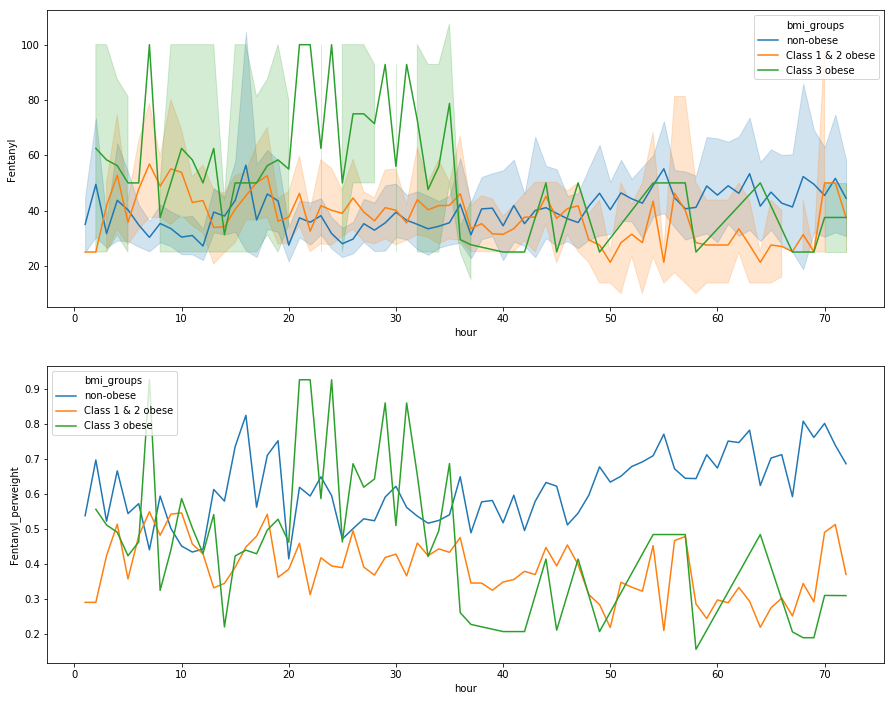

In [0]:
c = 'Fentanyl'
msk = (df[c] > 0) & (df.hour <73) & (df.vent > 0)
df[c + '_perweight'] = df[c] / df.weight
x = df[msk]
fig, ax = plt.subplots(nrows=2, figsize=(15, 12))
sns.lineplot(x=x.hour, y=x[c], hue=x.bmi_groups, ci=95, ax=ax[0])
sns.lineplot(x=x.hour, y=x[c + '_perweight'], hue=x.bmi_groups, ci=None, ax=ax[1])

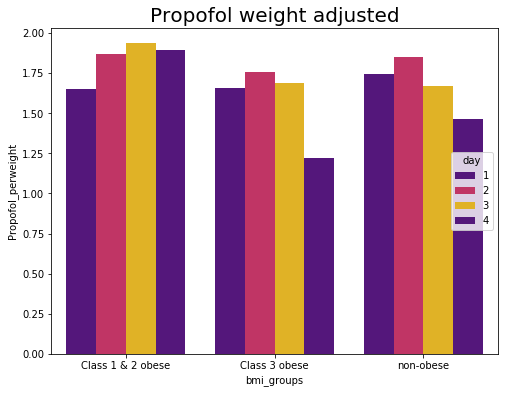

In [0]:
fig, ax = plt.subplots(1, figsize=(8, 6))
sns.barplot(y=stat.Propofol_perweight, hue=stat.day, x=stat.bmi_groups, palette=['#57068C', '#d71e5e', '#FFC107'])
ax.legend(loc=5)
plt.title('Propofol weight adjusted', size=20)
ax.legend(loc=5, title='day')

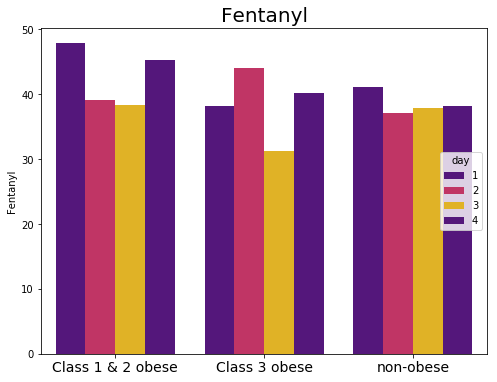

In [0]:
fig, ax = plt.subplots(1, figsize=(8, 6))

sns.barplot(y=stat.Fentanyl, hue=stat.day, x=stat.bmi_groups, palette=['#57068C', '#d71e5e', '#FFC107'])
ax.legend(loc=5)
plt.title('Fentanyl', size=20)
ax.set_xticklabels(ax.get_xticklabels(), size=14)
ax.set_xlabel('')
ax.legend(loc=5, title='day')

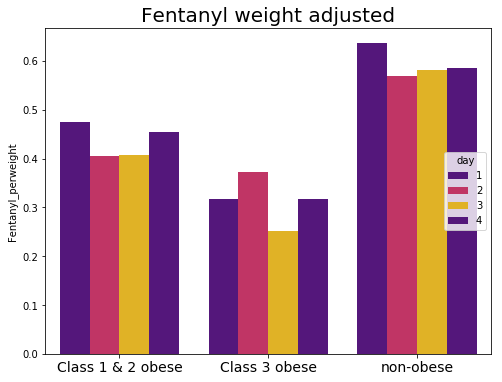

In [0]:

fig, ax = plt.subplots(1, figsize=(8, 6))

sns.barplot(y=stat.Fentanyl_perweight, hue=stat.day, x=stat.bmi_groups, palette=['#57068C', '#d71e5e', '#FFC107'])
ax.legend(loc=5)
plt.title('Fentanyl weight adjusted', size=20)
ax.set_xticklabels(ax.get_xticklabels(), size=14)
ax.set_xlabel('')
ax.legend(loc=5, title='day')

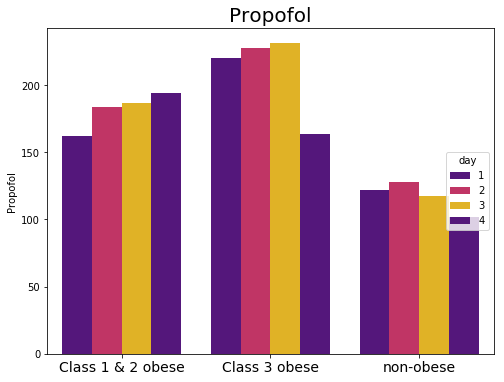

In [0]:

fig, ax = plt.subplots(1, figsize=(8, 6))

sns.barplot(y=stat.Propofol, hue=stat.day, x=stat.bmi_groups, palette=['#57068C', '#d71e5e', '#FFC107'])
ax.legend(loc=5)
plt.title('Propofol', size=20)
ax.set_xticklabels(ax.get_xticklabels(), size=14)
ax.set_xlabel('')
ax.legend(loc=5, title='day')

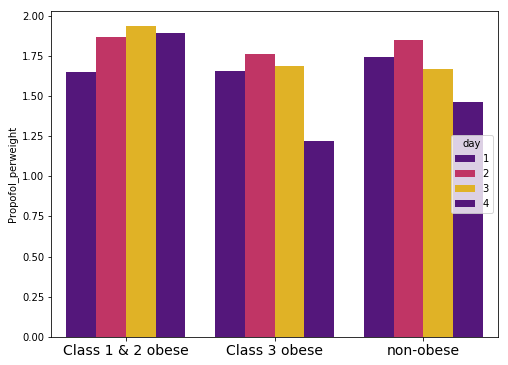

In [0]:

fig, ax = plt.subplots(1, figsize=(8, 6))

sns.barplot(y=stat.Propofol_perweight, hue=stat.day, x=stat.bmi_groups, palette=['#57068C', '#d71e5e', '#FFC107'])
ax.legend(loc=5)
ax.set_xticklabels(ax.get_xticklabels(), size=14)
ax.set_xlabel('')
ax.legend(loc=5, title='day')